# UNIT 4. Unsupervised Learning

This Unit includes main introduction to unsupervised learning, strongly based in {cite:p}`kroese2020`.

## EM: Univariate problem

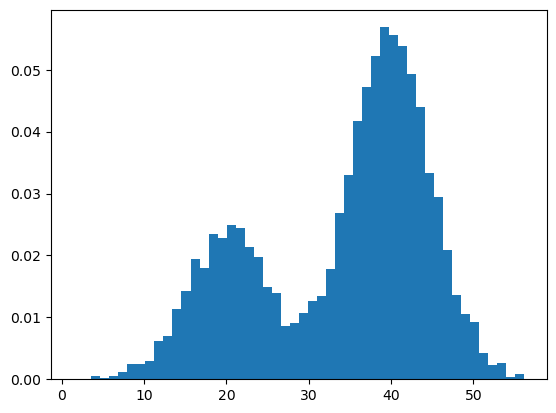

[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [66]:
from numpy import hstack
from numpy.random import normal
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
# generate a sample
X1 = normal(loc=20, scale=5, size=3000)
X2 = normal(loc=40, scale=5, size=7000)
X = hstack((X1, X2))
# plot the histogram
plt.hist(X, bins=50, density=True)
plt.show()
# reshape into a table with one column
X = X.reshape((len(X), 1))
# fit model
model = GaussianMixture(n_components=2, init_params='random')
model.fit(X)
yhat = model.predict(X) # predict latent values
print(yhat[:100])       # check latent value for first few points
print(yhat[-100:])      # check latent value for last few points

## EM: Multivariate case

We will code now a step by step example of the ME algorithm.

We will start by retaking the data in the K-Means experiment used in UNIT 2. Now, we are going to use the Expectation-Maximization (EM) algorithm.

In this exercise, we use 300 data points that were independently generated from three bivariate normal distributiuons with means:

| cluster  | mean vector  | covariance matrix  |
|---|---|---|
| 1 | $\begin{pmatrix}-4\\0\end{pmatrix}$    | $\begin{pmatrix}1&1.4\\1.4&1.5\end{pmatrix}$  |
| 2 | $\begin{pmatrix}0.5\\-1\end{pmatrix}$    |  $\begin{pmatrix}2&-0.95\\-0.95&1\end{pmatrix}$ |
| 3 | $\begin{pmatrix}-1.5\\-3\end{pmatrix}$    | $\begin{pmatrix}2&0.1\\0.1&0.1\end{pmatrix}$  |

<function matplotlib.pyplot.show(close=None, block=None)>

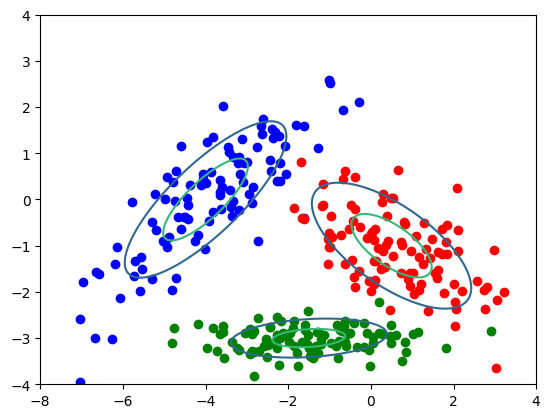

In [67]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

#Xmat = np.genfromtxt('datasets/clusterdata.csv', delimiter=',')

mean = []
cov = []
xmat = []


# define the means and covariances of the three pieces of the dataset
mean.append(np.array([-4, 0]))
cov.append(np.array([[2,1.4],[1.4,1.5]]))

mean.append(np.array([0.5, -1]))
cov.append(np.array([[2,-0.95],[-0.95,1]]))

mean.append(np.array([-1.5, -3]))
cov.append(np.array([[2,0.1],[0.1,0.1]]))

c=['b','r','g']
for i in range(3):
    data=np.random.multivariate_normal(mean[i],cov[i],100)
    xmat.append(data)
    plt.scatter(data[:,0],data[:,1],c=c[i])     # plot each sub dataset

Xmat = np.concatenate((xmat[0],xmat[1],xmat[2]),axis=0)

K = 3                   # number of cluster
n, D = Xmat.shape       # dimension of data

# plot the contours of the three Gaussians

for i in range(3):
    N    = 200
    X    = np.linspace(-8, 4, N)
    Y    = np.linspace(-4, 4, N)
    X, Y = np.meshgrid(X, Y)
    pos  = np.dstack((X, Y))
    rv   = multivariate_normal(mean[i], cov[i])
    Z    = rv.pdf(pos)
    plt.contour(X, Y, Z,levels=2)

plt.show

We will apply the Expectation-Maximization algorithm by introducing auxiliary variables. We use an initial guess of variables $W$

1. The input is the data and an initial guess for the parameters: weights of the Gaussians in the mixture, means and covariances for each
2. We assign the parameters and evaluate $\mu$ and $\mathrm{Cov}$ 
3. We continue iterating until convergence is reached

In [68]:
# convergence is very sensitive to the choce of initial parameters
# so we should try different initial possibilities
W = np.array([[1/3,1/3,1/3]])
M  = np.array([[-2.0,-4,0],[-3,1,-1]])  #stores the mu's as columns
C = np.zeros((3,2,2))

# we assume first the covariances in each distribution
C[:,0,0] = 1
C[:,1,1] = 1

p = np.zeros((3,300))
print(p.shape)

for i in range(0,100):      # let us iterate a given number of steps

    for k in range(0,K):    #E-step
        mvn = multivariate_normal( M[:,k].T, C[k,:,:] )
        p[k,:] = W[0,k]*mvn.pdf(Xmat)

    p = p/sum(p,0)   #normalize

    W = np.mean(p,1).reshape(1,3)
    for k in range(0,K):
        M[:,k] = (Xmat.T @ p[k,:].T)/sum(p[k,:])
        xm = Xmat.T - M[:,k].reshape(2,1)
        C[k,:,:] = xm @ (xm*p[k,:]).T/sum(p[k,:])

print(W)
print(M)
print(C)

(3, 300)
[[0.32524247 0.32183991 0.35291763]]
[[-1.60810838 -3.93698115  0.53988027]
 [-3.03312087  0.02345175 -1.09775777]]
[[[ 2.02309743  0.00512281]
  [ 0.00512281  0.07047106]]

 [[ 2.1764975   1.53790382]
  [ 1.53790382  1.55256854]]

 [[ 1.70274471 -0.64219255]
  [-0.64219255  0.75676483]]]


## PCA with Singular Value Decomposition

/var/folders/v5/vwzdch316vzcj9qldllr58800000gp/T/ipykernel_84491/4046058637.py:19: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((0, 0, 0, 0))


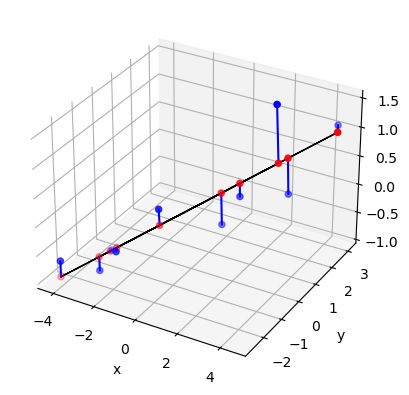

In [70]:
""" PCAdat.py """
import numpy as np 
X = np.genfromtxt('datasets/pcadat.csv', delimiter=',')

n = X.shape[0]

# Gram matrix
X = X - X.mean(axis=0)
G = X.T @ X 
U, _ , _ = np.linalg.svd(G/n)

# projected points first component
Y = X @ np.outer(U[:,0],U[:,0])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color((0, 0, 0, 0))
ax.plot(Y[:,0], Y[:,1], Y[:,2], c='k', linewidth=1)
ax.scatter(X[:,0], X[:,1], X[:,2], c='b')
ax.scatter(Y[:,0], Y[:,1], Y[:,2], c='r')

for i in range(n):
    ax.plot([X[i,0], Y[i,0]], [X[i,1],Y[i,1]], [X[i,2],Y[i,2]], 'b')
    
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
plt.savefig('../figures/pca1py.pdf')
plt.show()
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

```{bibliography}
:style: unsrt
```